In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
from google.colab import drive
import shutil
import random

# Mount Google Drive
# drive.mount('/content/drive')

# Paths
BASE_DIR = "/content/drive/MyDrive/microplastics"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train/images")
TRAIN_LABEL_DIR = os.path.join(BASE_DIR, "train/labels")

OUTPUT_DIR = "/content/drive/MyDrive/microplastics_augmented"
OUTPUT_IMG_DIR = os.path.join(OUTPUT_DIR, "train/images")
OUTPUT_LABEL_DIR = os.path.join(OUTPUT_DIR, "train/labels")

# Create output folders
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# Define Augmentations
flip_h_transform = A.HorizontalFlip(p=1.0)
flip_v_transform = A.VerticalFlip(p=1.0)
gaussian_noise_transform = A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)
sp_noise_transform = A.ISONoise(p=1.0)

# Get image files
image_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith(('.jpg', '.png'))]
random.shuffle(image_files)  # Shuffle to ensure randomness

total_images = len(image_files)
half_images = total_images // 2
thirty_percent_images = int(total_images * 0.3)

# Select images for specific augmentations
v_flip_images = image_files[:half_images]  # 50% of images for vertical flip
gaussian_images = image_files[:half_images]  # 50% of images for Gaussian Noise
sp_images = image_files[:thirty_percent_images]  # 30% of images for SP Noise

def update_label(original_label_path, new_label_path, aug_type):
    """Updates label file for flipping transformations."""
    with open(original_label_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        data = line.strip().split()
        cls, x, y, w, h = int(data[0]), float(data[1]), float(data[2]), float(data[3]), float(data[4])

        # Apply flipping transformations
        if aug_type == "flip_h":
            x = 1 - x
        elif aug_type == "flip_v":
            y = 1 - y

        new_lines.append(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    # Save updated label
    with open(new_label_path, 'w') as f:
        f.write("\n".join(new_lines))

# Apply augmentations
for img_name in tqdm(image_files):
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(TRAIN_LABEL_DIR, label_name)

    # Read image
    img = cv2.imread(img_path)

    # Save original image & label
    shutil.copy(img_path, os.path.join(OUTPUT_IMG_DIR, img_name))
    shutil.copy(label_path, os.path.join(OUTPUT_LABEL_DIR, label_name))

    # Horizontal Flip (100%)
    flipped_h_img = flip_h_transform(image=img)['image']
    flipped_h_img_name = os.path.splitext(img_name)[0] + "_flip_h.jpg"
    flipped_h_img_path = os.path.join(OUTPUT_IMG_DIR, flipped_h_img_name)
    flipped_h_label_path = os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_name)[0] + "_flip_h.txt")

    # Save flipped image & update label
    cv2.imwrite(flipped_h_img_path, flipped_h_img)
    update_label(label_path, flipped_h_label_path, "flip_h")

    # Vertical Flip (50%)
    if img_name in v_flip_images:
        flipped_v_img = flip_v_transform(image=img)['image']
        flipped_v_img_name = os.path.splitext(img_name)[0] + "_flip_v.jpg"
        flipped_v_img_path = os.path.join(OUTPUT_IMG_DIR, flipped_v_img_name)
        flipped_v_label_path = os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_name)[0] + "_flip_v.txt")

        cv2.imwrite(flipped_v_img_path, flipped_v_img)
        update_label(label_path, flipped_v_label_path, "flip_v")

    # Gaussian Noise (50%) + Flip
    if img_name in gaussian_images:
        noisy_img = gaussian_noise_transform(image=img)['image']
        noisy_img_name = os.path.splitext(img_name)[0] + "_gaussian.jpg"
        noisy_img_path = os.path.join(OUTPUT_IMG_DIR, noisy_img_name)
        noisy_label_path = os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_name)[0] + "_gaussian.txt")

        cv2.imwrite(noisy_img_path, noisy_img)
        shutil.copy(label_path, noisy_label_path)

        # Flip Gaussian Noise
        flipped_noisy_img = flip_h_transform(image=noisy_img)['image']
        flipped_noisy_img_name = os.path.splitext(img_name)[0] + "_gaussian_flip.jpg"
        flipped_noisy_img_path = os.path.join(OUTPUT_IMG_DIR, flipped_noisy_img_name)
        flipped_noisy_label_path = os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_name)[0] + "_gaussian_flip.txt")

        cv2.imwrite(flipped_noisy_img_path, flipped_noisy_img)
        update_label(noisy_label_path, flipped_noisy_label_path, "flip_h")

    # Salt & Pepper Noise (30%) + Flip
    if img_name in sp_images:
        sp_noisy_img = sp_noise_transform(image=img)['image']
        sp_noisy_img_name = os.path.splitext(img_name)[0] + "_sp_noise.jpg"
        sp_noisy_img_path = os.path.join(OUTPUT_IMG_DIR, sp_noisy_img_name)
        sp_noisy_label_path = os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_name)[0] + "_sp_noise.txt")

        cv2.imwrite(sp_noisy_img_path, sp_noisy_img)
        shutil.copy(label_path, sp_noisy_label_path)

        # Flip SP Noise
        flipped_sp_noisy_img = flip_h_transform(image=sp_noisy_img)['image']
        flipped_sp_noisy_img_name = os.path.splitext(img_name)[0] + "_sp_noise_flip.jpg"
        flipped_sp_noisy_img_path = os.path.join(OUTPUT_IMG_DIR, flipped_sp_noisy_img_name)
        flipped_sp_noisy_label_path = os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_name)[0] + "_sp_noise_flip.txt")

        cv2.imwrite(flipped_sp_noisy_img_path, flipped_sp_noisy_img)
        update_label(sp_noisy_label_path, flipped_sp_noisy_label_path, "flip_h")

print("Data Augmentation Completed Successfully!")


<ipython-input-2-4911b47b7791>:29: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  gaussian_noise_transform = A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)
100%|██████████| 320/320 [04:17<00:00,  1.24it/s]

✅ Data Augmentation Completed Successfully!


In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
import random

# Define Lighting Variation Augmentation
lighting_transform = A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0)

# Paths (Modify these if needed)
BASE_DIR = "/content/drive/MyDrive/microplastics"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train/images")
TRAIN_LABEL_DIR = os.path.join(BASE_DIR, "train/labels")
OUTPUT_DIR = "/content/drive/MyDrive/microplastics_augmented"
OUTPUT_IMG_DIR = os.path.join(OUTPUT_DIR, "train/images")
OUTPUT_LABEL_DIR = os.path.join(OUTPUT_DIR, "train/labels")

# Get image files
image_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith(('.jpg', '.png'))]
random.shuffle(image_files)  # Shuffle to ensure randomness

# Select 30% of images for lighting variation
lighting_images = image_files[:int(len(image_files) * 0.3)]

# Apply lighting variation to selected images
for img_name in tqdm(lighting_images):
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(TRAIN_LABEL_DIR, label_name)

    # Read image
    img = cv2.imread(img_path)

    # Apply lighting augmentation
    lighting_img = lighting_transform(image=img)['image']
    lighting_img_name = os.path.splitext(img_name)[0] + "_lighting.jpg"
    lighting_img_path = os.path.join(OUTPUT_IMG_DIR, lighting_img_name)
    lighting_label_path = os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_name)[0] + "_lighting.txt")

    # Save augmented image & copy label
    cv2.imwrite(lighting_img_path, lighting_img)
    shutil.copy(label_path, lighting_label_path)

print("Lighting Variation Augmentation Completed for 30% of Images!")


100%|██████████| 96/96 [00:03<00:00, 28.66it/s]

✅ Lighting Variation Augmentation Completed for 30% of Images!


In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
BASE_DIR = "/content/drive/MyDrive/microplastics"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train/images")
TRAIN_LABEL_DIR = os.path.join(BASE_DIR, "train/labels")

OUTPUT_DIR = "/content/drive/MyDrive/microplastics_augmented"
OUTPUT_IMG_DIR = os.path.join(OUTPUT_DIR, "train/images")
OUTPUT_LABEL_DIR = os.path.join(OUTPUT_DIR, "train/labels")

# Create output folders
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# Define Motion Blur Augmentation
motion_blur = A.MotionBlur(blur_limit=(3, 7), p=1.0)

# Get image files
image_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith(('.jpg', '.png'))]

def copy_label(original_label_path, new_label_path):
    """Copy label file as motion blur does not change labels"""
    os.system(f"cp {original_label_path} {new_label_path}")

# Apply Motion Blur & Save Images/Labels
for img_name in tqdm(image_files):
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)
    label_path = os.path.join(TRAIN_LABEL_DIR, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Read image
    img = cv2.imread(img_path)

    # Apply motion blur
    aug_img = motion_blur(image=img)['image']
    aug_img_name = img_name.replace(".jpg", "_motionblur.jpg").replace(".png", "_motionblur.png")
    aug_img_path = os.path.join(OUTPUT_IMG_DIR, aug_img_name)
    aug_label_path = os.path.join(OUTPUT_LABEL_DIR, aug_img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Save augmented image & copy label
    cv2.imwrite(aug_img_path, aug_img)
    copy_label(label_path, aug_label_path)

print("Motion Blur Augmentation Completed!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 320/320 [00:10<00:00, 30.04it/s]

✅ Motion Blur Augmentation Completed!


In [ ]:
import os
from collections import defaultdict

# Path to the augmented images folder
AUGMENTED_IMG_DIR = "/content/drive/MyDrive/microplastics_augmented/train/images"

# Dictionary to store augmentation type counts
augmentation_counts = defaultdict(int)

# Identify augmentation types from file names
for img_file in os.listdir(AUGMENTED_IMG_DIR):
    if img_file.endswith(('.jpg', '.png')):  # Ensure it's an image file
        if "_flip_h" in img_file:
            augmentation_counts["Horizontal Flip"] += 1
        elif "_flip_v" in img_file:
            augmentation_counts["Vertical Flip"] += 1
        elif "_gaussian" in img_file:
            augmentation_counts["Gaussian Noise"] += 1
        elif "_gaussian_flip" in img_file:
            augmentation_counts["Gaussian Noise + Flip"] += 1
        elif "_sp_noise" in img_file:
            augmentation_counts["Salt & Pepper Noise"] += 1
        elif "_sp_noise_flip" in img_file:
            augmentation_counts["Salt & Pepper Noise + Flip"] += 1
        elif "_motionblur" in img_file:
            augmentation_counts["Motion Blur"] += 1
        elif "_lighting" in img_file:
            augmentation_counts["Lighting"] += 1
        else:
            augmentation_counts["Original"] += 1  # If no augmentation tag is found

# Print the final counts
print("Augmentation Type Counts:")
for aug_type, count in augmentation_counts.items():
    print(f"{aug_type}: {count} images")


Augmentation Type Counts:
Original: 320 images
Horizontal Flip: 320 images
Vertical Flip: 160 images
Gaussian Noise: 320 images
Salt & Pepper Noise: 192 images
Lighting: 96 images
Motion Blur: 320 images


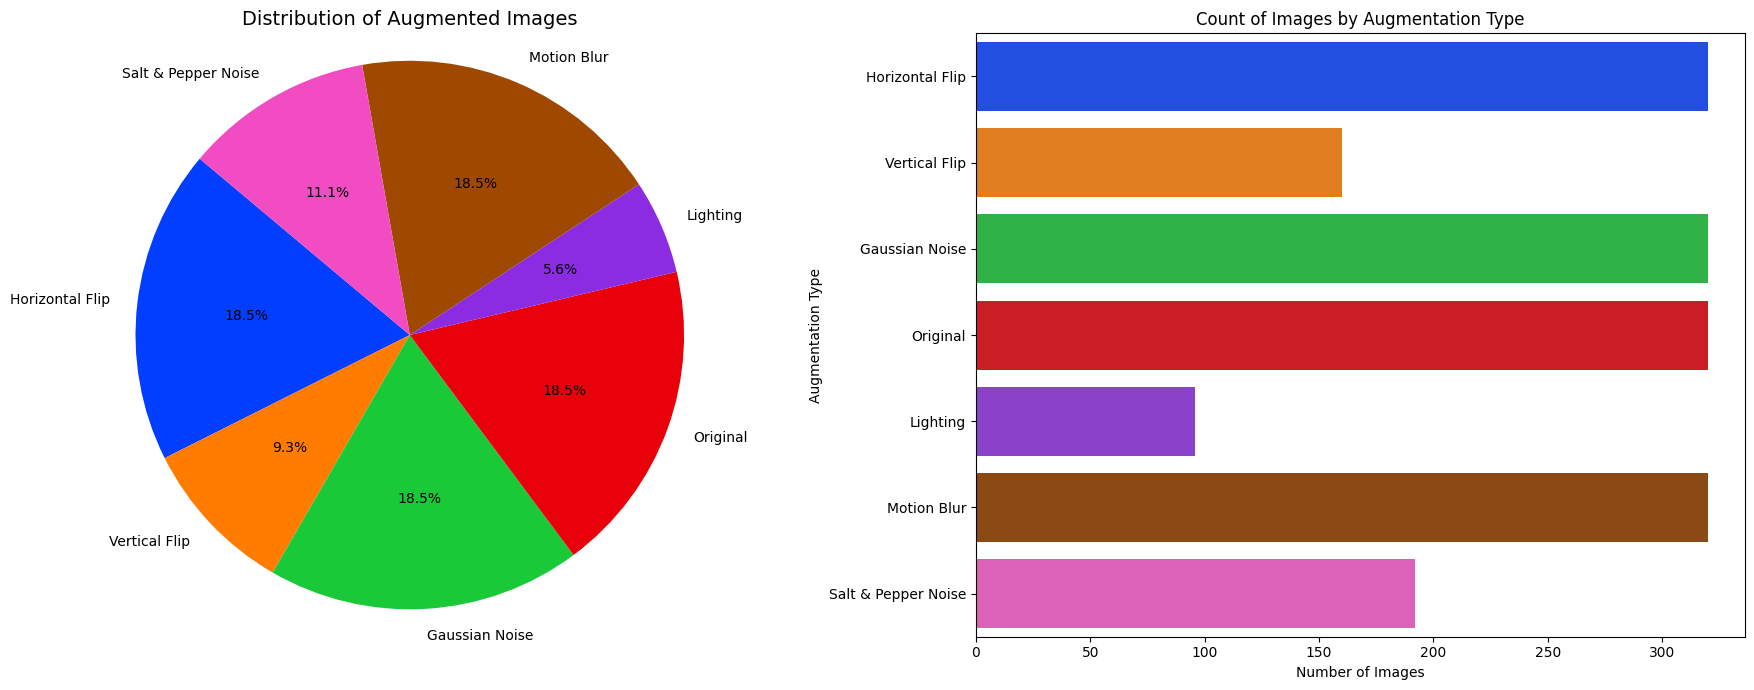

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Set path
AUGMENTED_IMG_DIR = "/content/drive/MyDrive/microplastics_augmented/train/images"

# Count augmentation types
augmentation_counts = defaultdict(int)

for img_file in os.listdir(AUGMENTED_IMG_DIR):
    if img_file.endswith(('.jpg', '.png')):
        if "_flip_h" in img_file:
            augmentation_counts["Horizontal Flip"] += 1
        elif "_flip_v" in img_file:
            augmentation_counts["Vertical Flip"] += 1
        elif "_gaussian" in img_file:
            augmentation_counts["Gaussian Noise"] += 1
        elif "_gaussian_flip" in img_file:
            augmentation_counts["Gaussian Noise + Flip"] += 1
        elif "_sp_noise" in img_file:
            augmentation_counts["Salt & Pepper Noise"] += 1
        elif "_sp_noise_flip" in img_file:
            augmentation_counts["Salt & Pepper Noise + Flip"] += 1
        elif "_motionblur" in img_file:
            augmentation_counts["Motion Blur"] += 1
        elif "_lighting" in img_file:
            augmentation_counts["Lighting"] += 1
        else:
            augmentation_counts["Original"] += 1

# Prepare data
aug_types = list(augmentation_counts.keys())
counts = [augmentation_counts[aug] for aug in aug_types]
colors = sns.color_palette('bright')[:len(aug_types)]

# -------------------------------
# Combined Plot: Pie Chart + Bar Chart Side by Side
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Pie Chart
axes[0].pie(counts, labels=aug_types, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title("Distribution of Augmented Images", fontsize=14)
axes[0].axis('equal')  # Keep pie chart circular

# Horizontal Bar Chart
sns.barplot(x=counts, y=aug_types, hue=aug_types, palette=colors, dodge=False, legend=False, ax=axes[1])
axes[1].set_xlabel("Number of Images")
axes[1].set_ylabel("Augmentation Type")
axes[1].set_title("Count of Images by Augmentation Type")

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm

# Paths
BASE_DIR = "/content/drive/MyDrive/microplastics"
TEST_IMG_DIR = os.path.join(BASE_DIR, "test/images")
TEST_LABEL_DIR = os.path.join(BASE_DIR, "test/labels")

OUTPUT_DIR = "/content/drive/MyDrive/microplastics_augmented"
OUTPUT_IMG_DIR = os.path.join(OUTPUT_DIR, "test/images")
OUTPUT_LABEL_DIR = os.path.join(OUTPUT_DIR, "test/labels")

# Create output folders
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# Augmentations
augmentations = {
    "flip_h": A.HorizontalFlip(p=1.0),
    "flip_v": A.VerticalFlip(p=1.0),
    "gaussian_noise": A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
    "sp_noise": A.ISONoise(p=1.0),
    "lighting": A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
    "motion_blur": A.MotionBlur(blur_limit=5, p=1.0),
}

# Image distribution for the test set
test_augmentation_counts = {
    "flip_h": 80,
    "flip_v": 40,
    "gaussian_noise": 80,
    "sp_noise": 48,
    "lighting": 24,
    "motion_blur": 80,
}

# Get image files
image_files = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith(('.jpg', '.png'))]

# Function to update labels after augmentation
def update_label(original_label_path, new_label_path, aug_type):
    """
    Adjusts label file for flipping (noise, lighting, and blur do not change labels)
    """
    with open(original_label_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        data = line.strip().split()
        cls, x, y, w, h = int(data[0]), float(data[1]), float(data[2]), float(data[3]), float(data[4])

        if aug_type == "flip_h":
            x = 1 - x  # Flip X-axis
        elif aug_type == "flip_v":
            y = 1 - y  # Flip Y-axis

        new_lines.append(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    with open(new_label_path, 'w') as f:
        f.write("\n".join(new_lines))

# Apply augmentations
for img_name in tqdm(image_files):
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    label_path = os.path.join(TEST_LABEL_DIR, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Read image
    img = cv2.imread(img_path)

    # Save original image & label
    cv2.imwrite(os.path.join(OUTPUT_IMG_DIR, img_name), img)
    os.system(f"cp {label_path} {os.path.join(OUTPUT_LABEL_DIR, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))}")

    # Apply augmentations with the defined counts
    for aug_type, count in test_augmentation_counts.items():
        if len(image_files) < count:
            selected_images = image_files
        else:
            selected_images = np.random.choice(image_files, count, replace=False)

        if img_name in selected_images:
            aug_img = augmentations[aug_type](image=img)['image']
            aug_img_name = img_name.replace(".jpg", f"_{aug_type}.jpg").replace(".png", f"_{aug_type}.png")
            aug_img_path = os.path.join(OUTPUT_IMG_DIR, aug_img_name)
            aug_label_path = os.path.join(OUTPUT_LABEL_DIR, aug_img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

            cv2.imwrite(aug_img_path, aug_img)

            # Update label only for flipped images
            if "flip" in aug_type:
                update_label(label_path, aug_label_path, aug_type)
            else:
                os.system(f"cp {label_path} {aug_label_path}")

print("Test Data Augmentation Completed Successfully!")


<ipython-input-8-91b5c88c658e>:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  "gaussian_noise": A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
100%|██████████| 80/80 [01:55<00:00,  1.45s/it]

✅ Test Data Augmentation Completed Successfully!


In [ ]:
import os
from collections import defaultdict

# Define test dataset directory
TEST_IMG_DIR = "/content/drive/MyDrive/microplastics_augmented/test/images"

# Initialize category counts
augmentation_counts = defaultdict(int)

# Count images based on naming convention
for img_name in os.listdir(TEST_IMG_DIR):
    if img_name.endswith(('.jpg', '.png')):
        if "flip_h" in img_name:
            augmentation_counts["Horizontal Flip"] += 1
        elif "flip_v" in img_name:
            augmentation_counts["Vertical Flip"] += 1
        elif "gaussian_noise" in img_name:
            augmentation_counts["Gaussian Noise"] += 1
        elif "sp_noise" in img_name:
            augmentation_counts["Salt & Pepper Noise"] += 1
        elif "lighting" in img_name:
            augmentation_counts["Lighting"] += 1
        elif "motion_blur" in img_name:
            augmentation_counts["Motion Blur"] += 1
        else:
            augmentation_counts["Original"] += 1  # Images without augmentation tags

# Print augmentation counts
print("Test Dataset Augmentation Type Counts:")
for aug_type, count in augmentation_counts.items():
    print(f"{aug_type}: {count} images")


Test Dataset Augmentation Type Counts:
Original: 80 images
Horizontal Flip: 80 images
Vertical Flip: 44 images
Gaussian Noise: 80 images
Salt & Pepper Noise: 52 images
Motion Blur: 80 images
Lighting: 20 images


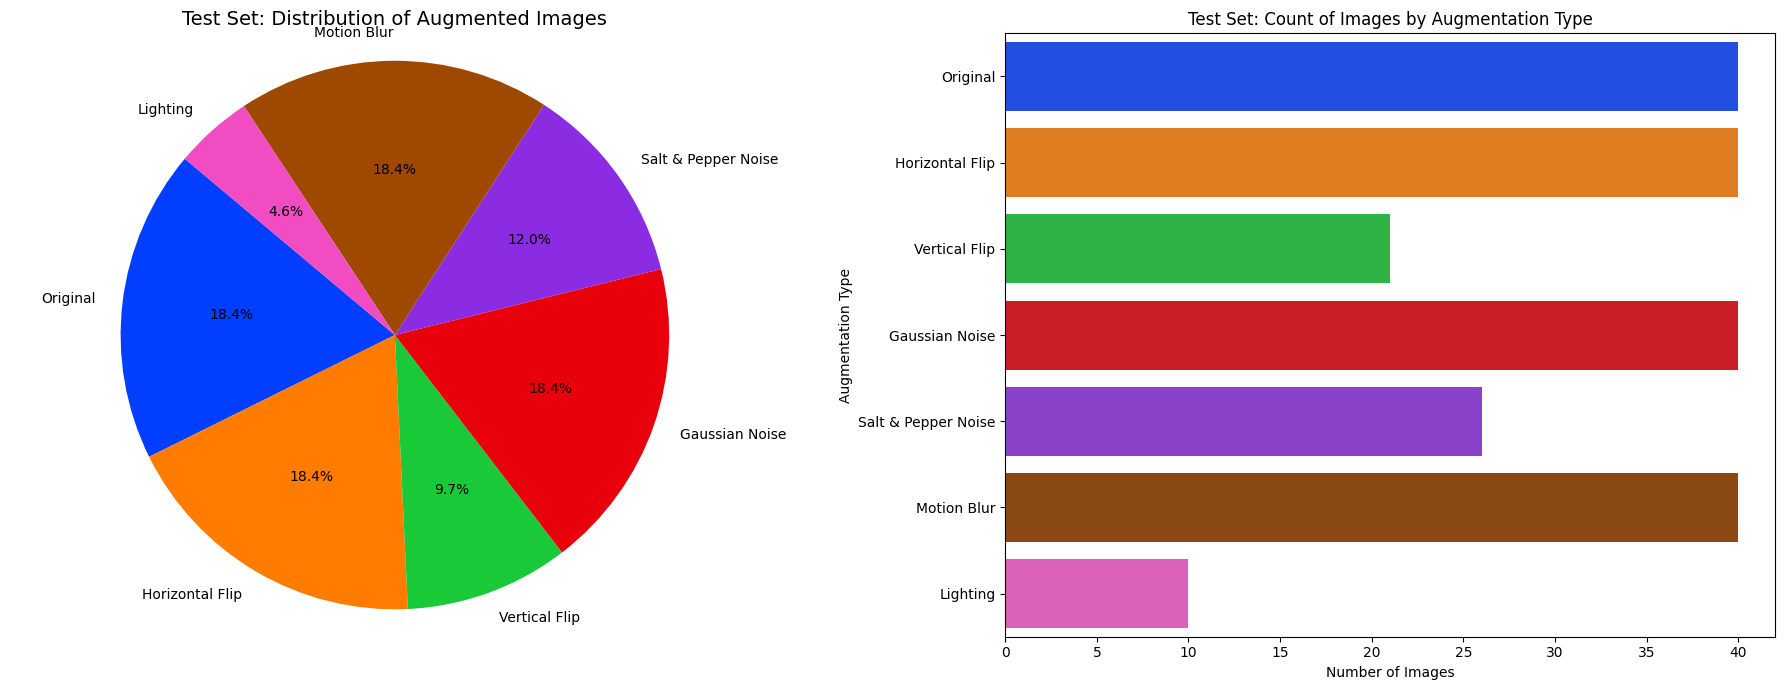

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Path to test images
TEST_IMG_DIR = "/content/drive/MyDrive/microplastics_augmented/test/images"

# Count augmentations
augmentation_counts = defaultdict(int)

for img_name in os.listdir(TEST_IMG_DIR):
    if img_name.endswith(('.jpg', '.png')):
        if "flip_h" in img_name:
            augmentation_counts["Horizontal Flip"] += 1
        elif "flip_v" in img_name:
            augmentation_counts["Vertical Flip"] += 1
        elif "gaussian_noise" in img_name:
            augmentation_counts["Gaussian Noise"] += 1
        elif "sp_noise" in img_name:
            augmentation_counts["Salt & Pepper Noise"] += 1
        elif "lighting" in img_name:
            augmentation_counts["Lighting"] += 1
        elif "motion_blur" in img_name:
            augmentation_counts["Motion Blur"] += 1
        else:
            augmentation_counts["Original"] += 1

# Prepare data
aug_types = list(augmentation_counts.keys())
counts = [augmentation_counts[aug] for aug in aug_types]
colors = sns.color_palette('bright')[:len(aug_types)]

# -------------------------------
# Combined Pie Chart + Bar Chart
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Pie Chart
axes[0].pie(counts, labels=aug_types, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title("Test Set: Distribution of Augmented Images", fontsize=14)
axes[0].axis('equal')

# Horizontal Bar Chart
sns.barplot(x=counts, y=aug_types, hue=aug_types, palette=colors, dodge=False, legend=False, ax=axes[1])
axes[1].set_xlabel("Number of Images")
axes[1].set_ylabel("Augmentation Type")
axes[1].set_title("Test Set: Count of Images by Augmentation Type")

plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil
import random
from collections import defaultdict

# Define paths
BASE_DIR = "/content/drive/MyDrive/microplastics_augmented"
TEST_IMG_DIR = os.path.join(BASE_DIR, "test/images")
TEST_LABEL_DIR = os.path.join(BASE_DIR, "test/labels")

VAL_IMG_DIR = os.path.join(BASE_DIR, "val/images")
VAL_LABEL_DIR = os.path.join(BASE_DIR, "val/labels")

# Create val directories
os.makedirs(VAL_IMG_DIR, exist_ok=True)
os.makedirs(VAL_LABEL_DIR, exist_ok=True)

# Step 1: Group files by base name
grouped_files = defaultdict(list)

for fname in os.listdir(TEST_IMG_DIR):
    if fname.endswith((".jpg", ".png")):
        base = fname.split("_")[0] if "_" in fname else fname.rsplit(".", 1)[0]
        grouped_files[base].append(fname)

# Step 2: Randomly choose 50% of base images
base_names = list(grouped_files.keys())
random.shuffle(base_names)
val_base_names = base_names[:len(base_names)//2]

# Step 3: Move files
for base in val_base_names:
    for img_fname in grouped_files[base]:
        # Move image
        img_src = os.path.join(TEST_IMG_DIR, img_fname)
        img_dst = os.path.join(VAL_IMG_DIR, img_fname)
        shutil.move(img_src, img_dst)

        # Move label
        label_fname = img_fname.rsplit(".", 1)[0] + ".txt"
        label_src = os.path.join(TEST_LABEL_DIR, label_fname)
        label_dst = os.path.join(VAL_LABEL_DIR, label_fname)
        if os.path.exists(label_src):
            shutil.move(label_src, label_dst)

print(f"✅ Done! Moved {len(val_base_names)} base image groups to validation set.")


✅ Done! Moved 40 base image groups to validation set.


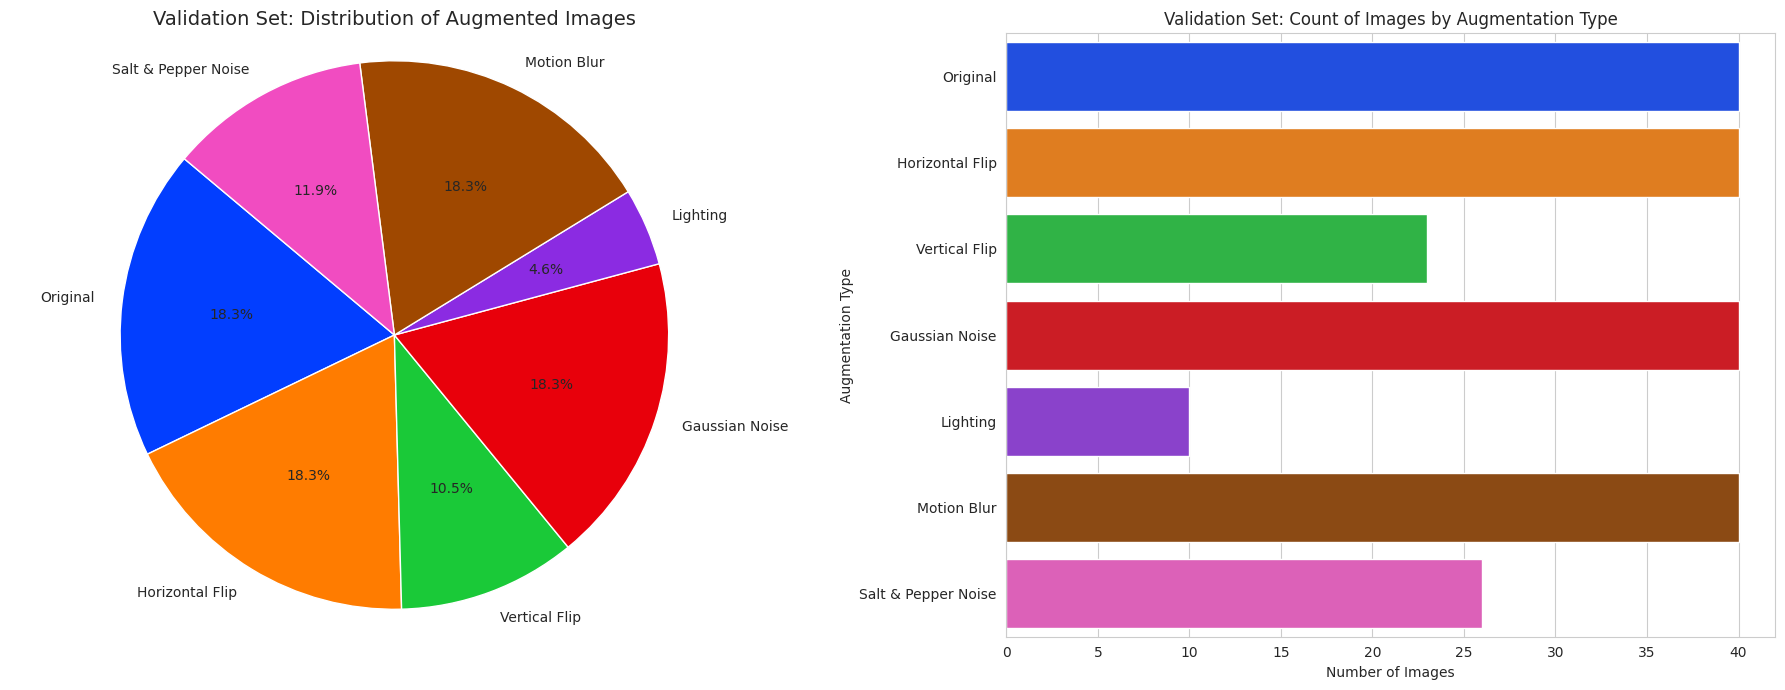

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Path to test images
TEST_IMG_DIR = "/content/drive/MyDrive/microplastics_augmented/val/images"

# Count augmentations
augmentation_counts = defaultdict(int)

for img_name in os.listdir(TEST_IMG_DIR):
    if img_name.endswith(('.jpg', '.png')):
        if "flip_h" in img_name:
            augmentation_counts["Horizontal Flip"] += 1
        elif "flip_v" in img_name:
            augmentation_counts["Vertical Flip"] += 1
        elif "gaussian_noise" in img_name:
            augmentation_counts["Gaussian Noise"] += 1
        elif "sp_noise" in img_name:
            augmentation_counts["Salt & Pepper Noise"] += 1
        elif "lighting" in img_name:
            augmentation_counts["Lighting"] += 1
        elif "motion_blur" in img_name:
            augmentation_counts["Motion Blur"] += 1
        else:
            augmentation_counts["Original"] += 1

# Prepare data
aug_types = list(augmentation_counts.keys())
counts = [augmentation_counts[aug] for aug in aug_types]
colors = sns.color_palette('bright')[:len(aug_types)]

# -------------------------------
# Combined Pie Chart + Bar Chart
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Pie Chart
axes[0].pie(counts, labels=aug_types, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title("Validation Set: Distribution of Augmented Images", fontsize=14)
axes[0].axis('equal')

# Horizontal Bar Chart
sns.barplot(x=counts, y=aug_types, hue=aug_types, palette=colors, dodge=False, legend=False, ax=axes[1])
axes[1].set_xlabel("Number of Images")
axes[1].set_ylabel("Augmentation Type")
axes[1].set_title("Validation Set: Count of Images by Augmentation Type")

plt.tight_layout()
plt.show()


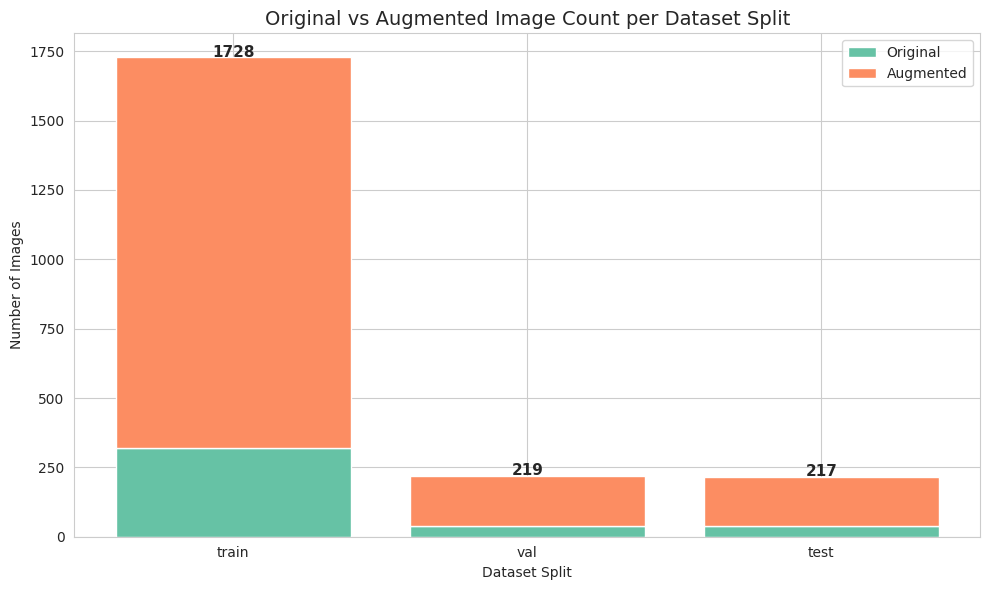

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Path to dataset
BASE_PATH = "/content/drive/MyDrive/microplastics_augmented"
SUBSETS = ["train", "val", "test"]
AUG_TAGS = ["flip", "gaussian", "sp_noise", "lighting", "motion"]

# Count structure: subset -> category -> count
data_counts = defaultdict(lambda: {"Original": 0, "Augmented": 0})

# Go through each subset
for subset in SUBSETS:
    img_dir = os.path.join(BASE_PATH, subset, "images")
    if not os.path.exists(img_dir):
        continue
    for img_file in os.listdir(img_dir):
        if img_file.endswith(('.jpg', '.png')):
            is_augmented = any(tag in img_file for tag in AUG_TAGS)
            if is_augmented:
                data_counts[subset]["Augmented"] += 1
            else:
                data_counts[subset]["Original"] += 1

# Prepare data for plotting
subset_labels = SUBSETS
original_counts = [data_counts[subset]["Original"] for subset in subset_labels]
augmented_counts = [data_counts[subset]["Augmented"] for subset in subset_labels]

# Set plot style
sns.set_style("whitegrid")
colors = sns.color_palette("Set2")

# Plot
plt.figure(figsize=(10, 6))
bar1 = plt.bar(subset_labels, original_counts, label="Original", color=colors[0])
bar2 = plt.bar(subset_labels, augmented_counts, bottom=original_counts, label="Augmented", color=colors[1])

# Annotate bars
for i in range(len(subset_labels)):
    total = original_counts[i] + augmented_counts[i]
    plt.text(i, total + 2, str(total), ha='center', fontsize=11, fontweight='bold')

plt.title("Original vs Augmented Image Count per Dataset Split", fontsize=14)
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.legend()
plt.tight_layout()
plt.show()
